# Training a fruit classifier with callbacks in Keras

## Upload and extract the dataset from Google Drive

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

'004 - Asynchronous Parallel Game-Tree Search (1998) .pdf'
'04 06 - 10 06.gsheet'
 183.pdf
 9781786464392-ARTIFICIAL_INTELLIGENCE_WITH_PYTHON.pdf
'action_model1 (1).h5'
 action_model1.h5
'Apresentação sem título.gslides'
'Artigos Interessantes RoboCup.gdoc'
 Backup
 BACKUP_LDA.rar
 Beginning-Game-Development-With-Python-And-Pygame-2007-McGugan.pdf
'CARTA MOTIVAÇÃO.gdoc'
 CM
'Colab Notebooks'
'Computação Científica com Python.pdf'
'Congressos IA 2018.gsheet'
'Controle Financeiro.gsheet'
 curriculo.xml
'Curriculum Vitae - Rita Maria da Silva Julia.gdoc'
'Documento sem título.gdoc'
 dogsXcats.zip
 EA_Content_Usage_Permission_Request_Form_022516.pdf
'Fifa Learning.rar'
 fruits-360.tar.gz
 game-tree-search-on-massively-parallel-systems.pdf
 GBC043_Aula24_KAREN.sql
'Gmail - ICTAI 2017 submission 209.pdf'
 Invent-Your-Own-Computer-Games-with-Python-2e-2010-Sweigart.pdf
 JogadorValquiria.zip
'LabBruno (1).rar'
'LabBruno (2).rar'
'LabBruno (3).rar'
 LabBruno.rar
'LabMariana (1).rar'
 L

In [0]:
import os
import tarfile

local_tar_gz = '/content/drive/My Drive/fruits-360.tar.gz'
tar_gz_ref = tarfile.open(local_tar_gz, "r:gz")
tar_gz_ref.extractall('/tmp')
tar_gz_ref.close()

## Creating generators

In [4]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 16

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/tmp/fruits-360/train'
validation_data_dir = '/tmp/fruits-360/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Using TensorFlow backend.


Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


## Building the model

In [5]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [6]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("/tmp/fruits_fresh_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20
2582/2582 [==============================] - 75s 29ms/step - loss: 1.8132 - acc: 0.4577 - val_loss: 0.4788 - val_acc: 0.8303

Epoch 00001: val_loss improved from inf to 0.47885, saving model to /tmp/fruits_fresh_cnn_1.h5
Epoch 2/20
2582/2582 [==============================] - 72s 28ms/step - loss: 0.6229 - acc: 0.8027 - val_loss: 0.2609 - val_acc: 0.9081

Epoch 00002: val_loss improved from 0.47885 to 0.26094, saving model to /tmp/fruits_fresh_cnn_1.h5
Epoch 3/20
2582/2582 [==============================] - 71s 28ms/step - loss: 0.4843 - acc: 0.8523 - val_loss: 0.4327 - val_acc: 0.8679

Epoch 00003: val_loss did not improve from 0.26094
Epoch 4/20
2582/2582 [==============================] - 72s 28ms/step - loss: 0.4520 - acc: 0.8714 - val_loss: 0.6878 - val_acc: 0.7929

Epoch 00004: val_loss did not improve from 0.26094
Epoch 5/20
2582/2582 [==============================] - 72s 28ms/step - loss: 0.4820 - acc: 0.8746 - val_loss: 0.5124 - val_acc: 0.8553
Restoring model weig

## Displaying the confusion matrix

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 66  77   0 ...   0   0   0]
 [  0  68  96 ...   0   0   0]
 [  0   0  48 ...   0   0   0]
 ...
 [  0   0   0 ...  68  96   0]
 [  0   0   0 ...   0  31  96]
 [ 40   0   0 ...   0   0 152]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.43      0.40      0.42       164
     Apple Golden 1       0.45      0.41      0.43       164
     Apple Golden 2       0.33      0.29      0.31       164
     Apple Golden 3       0.35      0.40      0.37       161
 Apple Granny Smith       0.41      0.41      0.41       164
        Apple Red 1       0.31      0.41      0.36       164
        Apple Red 2       0.28      0.22      0.25       164
        Apple Red 3       0.33      0.33      0.33       144
Apple Red Delicious       0.42      0.42      0.42       166
   Apple Red Yellow       0.67      0.41      0.51       164
            Apricot       0.41      0.41      0.41       164
            Avocado       0.33      

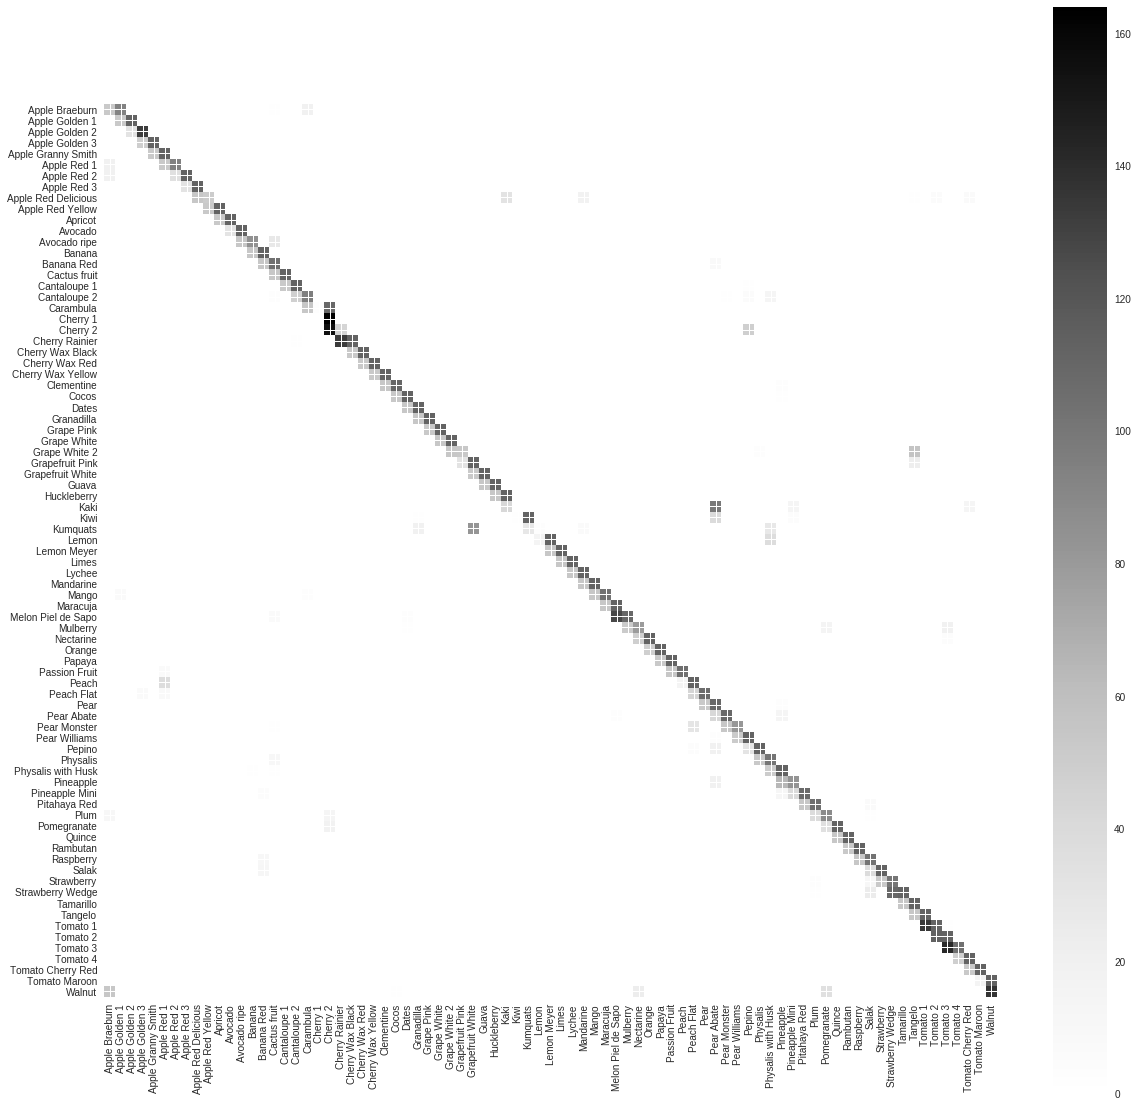

In [8]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('/tmp/fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 41322
nb_validation_samples = 13877

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)